# [VQ-VAE](https://arxiv.org/abs/1711.00937) for audio in PyTorch

Acknowledgements:
this notebook was 
https://github.com/zalandoresearch/pytorch-vq-vae

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation. 

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb). 

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector $e_i$.

The model will take in batches of waveforms, of size 16126 for our example, and pass it through a ConvNet encoder producing some output, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed audio. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is composed of three components:

1. reconstruction loss which optimizes the decoder and encoder
1. due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. also since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [24]:
import os
import subprocess

import math

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.optim as optim

from audio_loader import VCTK
from wavenet_vocoder.wavenet import WaveNet
from wavenet_vocoder.wavenet import receptive_field_size

In [2]:
device = torch.device("cpu")

In [3]:
class SubsetSequentialSampler(Sampler):
    r"""Samples elements from a given list of indices sequentially, always in the same order.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)
    
    def __len__(self):
        return len(self.indices)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCL` tensor of shape `[16, 64, 32]`, we will first convert it to an `BLC` tensor of shape `[16, 32, 64]` and then reshape it into `[512, 64]` and all `512` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `512` in this case. The number of channels of the encoder output must be equal to the embedding_dim.

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        assert len(inputs.shape) == 3
        # convert inputs from BCL -> BLC (B - batch size, C - channels, L - length)
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
    
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        #print("encoding_indices", encoding_indices.min(), encoding_indices.max())
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [5]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        assert inputs.max() > 0 or inputs.min() < 0
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        print("encoding_indices", encoding_indices.min(), encoding_indices.max())
        print("flat_input", flat_input.min(), flat_input.max())
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
    
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        loss = self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity

## Encoder & Decoder Architecture

In [6]:
class Encoder(nn.Module):
    """Audio encoder
    The vq-vae paper says that the encoder has 6 strided convolutions with stride 2 and window-size 4.
    The number of channels and a nonlinearity is not specified in the paper. I use ReLU.
    """
    def __init__(self, encoding_channels, in_channels=256):
        super(Encoder,self).__init__()
        self._num_layers = 2 * len(encoding_channels) - 1
        self._layers = nn.ModuleList()
        for out_channels in encoding_channels:
            self._layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    stride=2,
                                    kernel_size=4,
                                    padding=0, 
                                        ))
            self._layers.append(nn.ReLU())
            in_channels = out_channels
        self._layers = self._layers[:-1] #remove ReLu from last layer
        
    def forward(self, x):
        for i in range(self._num_layers):
            x = self._layers[i](x)
        return x

In [7]:
class Model(nn.Module):
    def __init__(self,
                 encoding_channels,
                 num_embeddings, 
                 embedding_dim,
                 commitment_cost, 
                 layers,
                 stacks,
                 kernel_size,
                 decay=0):
        super(Model, self).__init__()       
        self._encoder = Encoder(encoding_channels=encoding_channels)
        #I added batch normalization here, because:
        #the distribution of encoded values needs to be similar to the initial distribution of embedding vectors
        #otherwise we'll see "posterior collapse": all values will be assigned to the same embedding vector, and stay that way
        #Batch normalization is a simple way to achieve that goal
        self._batch_norm = nn.BatchNorm1d(1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = WaveNet(out_channels=256, #dimension of ohe mu-quantized signal
                                layers=layers, #like in original WaveNet
                                stacks=stacks,
                                residual_channels=512,
                                gate_channels=512,
                                skip_out_channels=512,
                                kernel_size=kernel_size, 
                                dropout=1 - 0.95,
                                cin_channels=1, #local conditioning channels - on encoder output
                                gin_channels=109, #global conditioning channels - on speaker_id
                                n_speakers=109,
                                weight_normalization=False, 
                                upsample_conditional_features=True, 
                                decoding_channels=encoding_channels[::-1],
                                use_speaker_embedding=False
                               )
        self.receptive_field = receptive_field_size(total_layers=layers, num_cycles=stacks, kernel_size=kernel_size)
    def forward(self, x):
        audio, target, speaker_id = x
        assert len(audio.shape) == 3 # B x C x L 
        assert audio.shape[1] == 256
        
        z = self._encoder(audio)
        z = self._batch_norm(z)
        vq_loss, quantized, perplexity = self._vq_vae(z)
        assert z.shape == quantized.shape
        x_recon = self._decoder(audio, quantized, speaker_id, softmax=False)
        
        x_recon = x_recon[:, :, self.receptive_field:]
        recon_loss = torch.nn.CrossEntropyLoss()
        recon_loss_value = recon_loss(x_recon, target)
        loss = recon_loss_value + vq_loss
        
        return loss, recon_loss_value, x_recon, perplexity

# Train

In [8]:
num_training_updates = 25000
#vector quantizer parameters:
encoding_channels = [32,16,8,4,2,1]
embedding_dim = 1 #dimension of each vector
num_embeddings = 512 #number of vectors
commitment_cost = 0.25

#wavenet parameters:
kernel_size=2
total_layers=30
num_cycles=3


#decay = 0.99
decay = 0

learning_rate = 3e-4

In [9]:
receptive_field = receptive_field_size(total_layers=total_layers, num_cycles=num_cycles, kernel_size=kernel_size)
print(receptive_field)

3070


## Load data

In [10]:
from audio_loader import VCTK

In [14]:
model = Model(num_embeddings=num_embeddings,
              encoding_channels=encoding_channels,
              embedding_dim=embedding_dim, 
              commitment_cost=commitment_cost, 
              layers=total_layers,
              stacks=num_cycles,
              kernel_size=kernel_size,
              decay=decay).to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [19]:
model.load_state_dict(torch.load("mymodel"))
optimizer.load_state_dict(torch.load("myoptim"))

In [20]:
data = VCTK("../VCTK", receptive_field=receptive_field)
print(len(data))
indices = np.arange(len(data))
test_size = len(data) // 10

group = optimizer.param_groups[0]
p = group['params'][0]
state = optimizer.state[p]
steps = state['step'] #how many optimizer steps were already taken
#NOTE: this code won't work correctly if you train for more than one epoch

train_indices = indices[steps:-test_size]
test_indices = indices[-test_size:]

training_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(train_indices))

validation_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(test_indices))

44242


In [21]:
len(train_indices), len(test_indices)

(39289, 4424)

In [22]:
iterator = iter(training_loader)

In [25]:
model.train()
# train_res_recon_error = []
# train_res_perplexity = []
with open("errors", "rb") as file:
    train_res_recon_error, train_res_perplexity = pickle.load(file)
    
for i in range(num_training_updates):
    data_train = next(iterator)

    optimizer.zero_grad()

    loss, recon_error, data_recon, perplexity = model(data_train)
    loss.backward()
    print("loss", loss.item())
    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 10 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.6f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

loss 0.00028561620274558663
loss 0.0001025840247166343
loss 0.00011367550905561075
loss 0.00017548481991980225
loss 0.00018662544607650489
loss 0.0003974003775510937
loss 0.0001632031926419586
loss 0.000307990878354758
loss 0.00026083385455422103
loss 7.482496584998444e-05
10 iterations
recon_error: 0.000339
perplexity: 8.343

loss 0.0002335222961846739
loss 8.732711285119876e-05
loss 0.00012162638449808583
loss 0.00020597832917701453
loss 0.0001403408678015694
loss 0.00022468237148132175
loss 0.00016981396765913814
loss 0.00015431827341672033
loss 0.0002069386828225106
loss 0.00014642566384281963
20 iterations
recon_error: 0.000291
perplexity: 8.366

loss 0.00018196525343228132
loss 0.0003333308268338442
loss 0.00024825130822137
loss 0.00010665678564691916
loss 0.00020938186207786202
loss 0.00014099891996011138
loss 0.0002623104373924434
loss 0.00012850058556068689
loss 7.528864807682112e-05
loss 0.00010412095434730873
30 iterations
recon_error: 0.000264
perplexity: 8.371

loss 0.0001

KeyboardInterrupt: 

Text(0.5,0,'iteration')

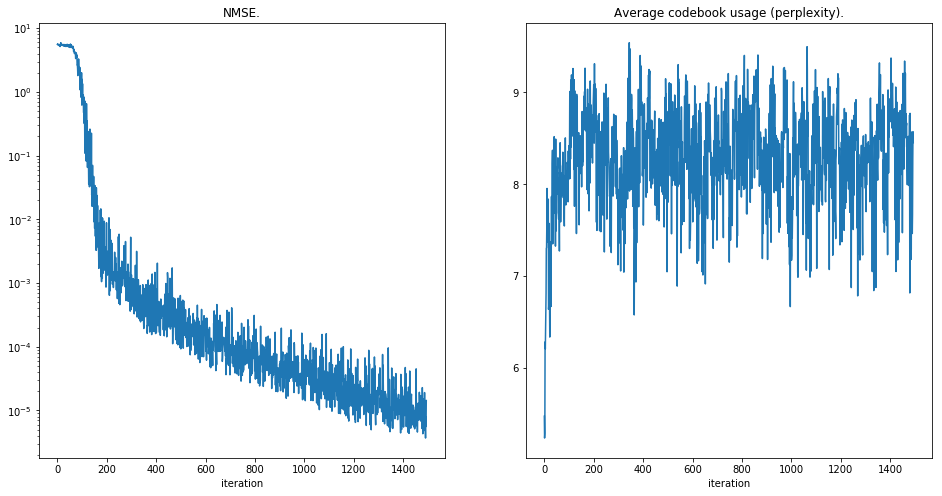

In [26]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [27]:
torch.save(model.state_dict(), "mymodel")
torch.save(optimizer.state_dict(), "myoptim")

In [28]:
import pickle
with open("errors", "wb") as file:
    pickle.dump([train_res_recon_error, train_res_perplexity], file)

In [ ]:
#test encoding-decoding
# import librosa
# audio, sr = librosa.load("../VCTK/wav48/p225/p225_001.wav")
# normalized = librosa.util.normalize(audio) #divide max(abs(audio))
# mu_x = data.mu_law_encode(normalized, 256)
# bins = np.linspace(-1, 1, 256)
# quantized = np.digitize(mu_x, bins) - 1
# plt.plot(quantized[:100])
# plt.show()

# mu_rec = (quantized + 1) / 128 - 1
# plt.plot(mu_rec[:1000], color='red')
# plt.plot(mu_x[:1000], color='blue')
# plt.show()

# decoded = data.mu_law_decode(mu_rec, 256)
# plt.plot(normalized[:1000], color='blue')
# plt.plot(decoded[:1000], color='red')
# plt.show()

In [29]:
model.eval()

#(valid_originals, _, speaker_id) = next(iter(training_loader))
data_train = data[train_indices[1]]
data_train = [data_train[0].to(device).unsqueeze(0), 
                  data_train[1].to(device).unsqueeze(0),
                  data_train[2].to(device).unsqueeze(0)]
#valid_originals = valid_originals.to(device)
valid_originals = data_train[0]
speaker_id = data_train[2]

with torch.no_grad():
    encoded = model._encoder(valid_originals)
    vq_output_eval = model._batch_norm(encoded)
    _, valid_quantize, _ = model._vq_vae(vq_output_eval)
    #valid_reconstructions = model._decoder(valid_originals, valid_quantize, speaker_id) - this one works fine
    valid_reconstructions = model._decoder.incremental_forward(valid_originals[:,:,0:1], 
                                                               valid_quantize, 
                                                               speaker_id, 
                                                               T=16126)

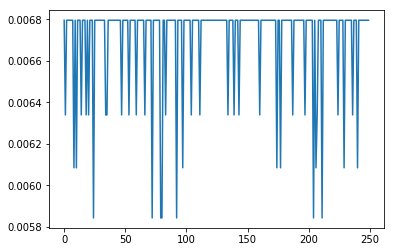

In [30]:
plt.plot(valid_quantize.detach().numpy().ravel())
plt.show()

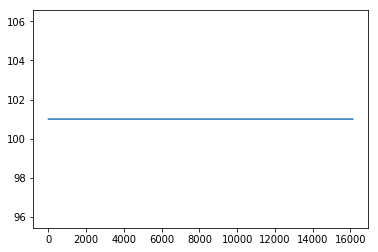

In [35]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().numpy()
plt.plot(recon)
plt.show()

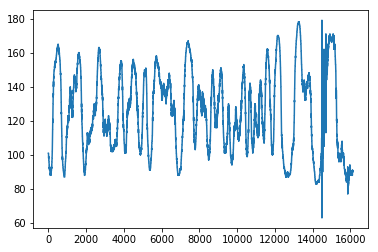

In [34]:
recon = valid_originals.squeeze().argmax(dim=0).detach().numpy()
#plt.plot(valid_quantize.detach().numpy().ravel())
plt.plot(recon)
plt.show()

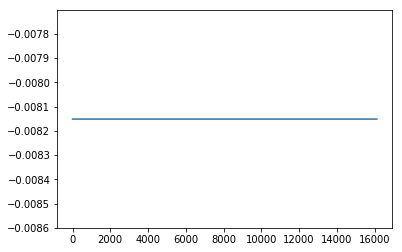

In [36]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = data.mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded)
plt.show()

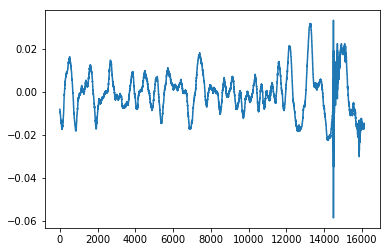

In [37]:
recon = valid_originals.squeeze().argmax(dim=0).detach().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = data.mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded)
plt.show()

In [40]:
from IPython.display import Audio, display

In [41]:
display(Audio(mu_decoded, rate=22050))

## View Embedding

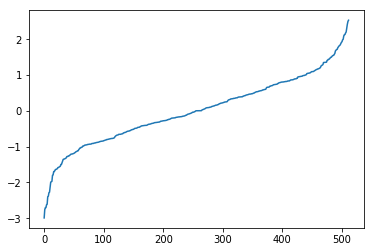

In [38]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
plt.plot(sorted(embeddings))
plt.show()